In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import datasets
import transformers

from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from transformers import AutoModel,AutoConfig
from torch.nn import MSELoss
from torch.utils.data import DataLoader
import torchmetrics
from torchmetrics.regression import R2Score
from transformers import AdamW
from transformers import get_scheduler

In [3]:
torch.cuda.empty_cache()

print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [4]:
modelpath = "zhihan1996/DNABERT-2-117M"

datapath  = '/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main'

df_train = pd.read_csv(f"{datapath}/sample_data/esp_biofeat/train_esp_biofeat_decoded.csv")
df_test = pd.read_csv(f"{datapath}/sample_data/esp_biofeat/test_esp_biofeat_decoded.csv")


#perform normalization on biofeat data
for col in df_train.columns[2:]:
    scaler = sklearn.preprocessing.MinMaxScaler()
    df_train[col] = scaler.fit_transform(df_train[col].values.reshape(-1,1))
    df_test[col] = scaler.transform(df_test[col].values.reshape(-1,1))


print(df_train.info())
print(df_train.head())

print(df_test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46893 entries, 0 to 46892
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   seq         46893 non-null  object 
 1   y           46893 non-null  float64
 2   biofeat_0   46893 non-null  float64
 3   biofeat_1   46893 non-null  float64
 4   biofeat_2   46893 non-null  float64
 5   biofeat_3   46893 non-null  float64
 6   biofeat_4   46893 non-null  float64
 7   biofeat_5   46893 non-null  float64
 8   biofeat_6   46893 non-null  float64
 9   biofeat_7   46893 non-null  float64
 10  biofeat_8   46893 non-null  float64
 11  biofeat_9   46893 non-null  float64
 12  biofeat_10  46893 non-null  float64
dtypes: float64(12), object(1)
memory usage: 4.7+ MB
None
                     seq         y  biofeat_0  biofeat_1  biofeat_2  \
0  GCCTGCGAAAAGAGCACGCGC  0.327296        0.0   0.574627   0.485876   
1  GAGGGGGCCGAGTCGATACTC  0.188169        0.0   0.985075   0.432203   
2  GT

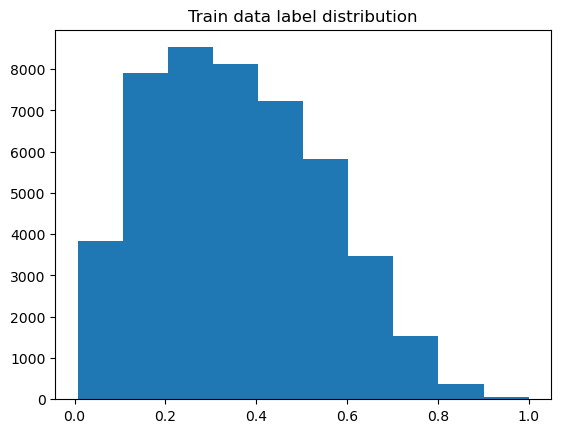

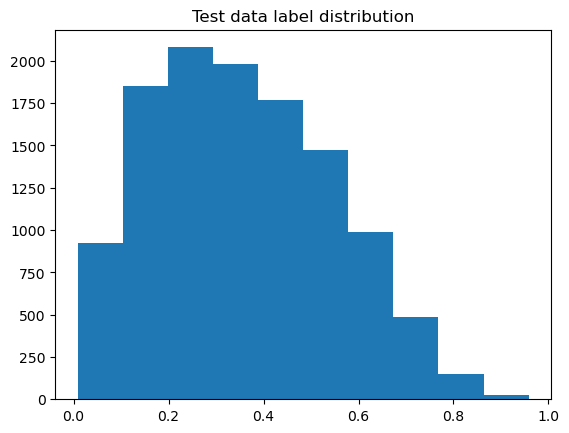

In [5]:
#plot label distribution of test and train data
plt.title("Train data label distribution")
plt.hist(df_train['y'])
plt.show()

plt.title("Test data label distribution")
plt.hist(df_test['y'])
plt.show()

In [6]:
#turn df into a dataset
raw_dataset_train = datasets.Dataset.from_pandas(df_train)
raw_dataset_test = datasets.Dataset.from_pandas(df_test)

print(raw_dataset_train)
print(raw_dataset_test)

Dataset({
    features: ['seq', 'y', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10'],
    num_rows: 46893
})
Dataset({
    features: ['seq', 'y', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10'],
    num_rows: 11724
})


In [7]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [8]:
def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset_train = raw_dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_train.set_format("torch")

print(tokenized_dataset_train)

tokenized_dataset_test = raw_dataset_test.map(tokenize_function, batched=True)
tokenized_dataset_test.set_format("torch")

print(tokenized_dataset_test)

Map:   0%|          | 0/46893 [00:00<?, ? examples/s]

Dataset({
    features: ['seq', 'y', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46893
})


Map:   0%|          | 0/11724 [00:00<?, ? examples/s]

Dataset({
    features: ['seq', 'y', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11724
})


In [9]:
def clean_tokenized_dataset(dataset):
    dataset = dataset.remove_columns(["seq"])
    dataset = dataset.rename_column("y", "labels")
    dataset.set_format("torch")

    print(dataset.column_names)
    return dataset

tokenized_dataset_train = clean_tokenized_dataset(tokenized_dataset_train)
tokenized_dataset_test = clean_tokenized_dataset(tokenized_dataset_test)

print(tokenized_dataset_train)
print(tokenized_dataset_test)

print(tokenized_dataset_train[0])

['labels', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10', 'input_ids', 'token_type_ids', 'attention_mask']
['labels', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10', 'input_ids', 'token_type_ids', 'attention_mask']
Dataset({
    features: ['labels', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 46893
})
Dataset({
    features: ['labels', 'biofeat_0', 'biofeat_1', 'biofeat_2', 'biofeat_3', 'biofeat_4', 'biofeat_5', 'biofeat_6', 'biofeat_7', 'biofeat_8', 'biofeat_9', 'biofeat_10', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 11724
})
{'labels': tensor(0.3273), 'biofeat_0': tensor(0.), 'biofeat_1': tensor(0.5746), 'biofea

In [10]:
print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)

3
100


In [11]:
batch_size = 512

train_dataloader = DataLoader(
    tokenized_dataset_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset_test, batch_size=batch_size, collate_fn=data_collator
)


In [12]:
from transformers import PreTrainedModel,AutoModel

class CustomModel(PreTrainedModel):
  config_class = AutoConfig

  def __init__(self, config): 
    super().__init__(config) 

    self.model = AutoModel.from_pretrained(
      modelpath,
      cache_dir=None,
      num_labels=1,
      trust_remote_code=True,
      ignore_mismatched_sizes=True)
    
    self.dropout = nn.Dropout(0.4)
    self.activation = nn.ELU()
    self.classifier1 = nn.Linear(779, 779)
    
    #set no grad for classifier1
    self.classifier1.weight.requires_grad = False

    self.classifier2 = nn.Linear(779, 389)
    self.classifier3 = nn.Linear(389, 320)
    self.classifier4 = nn.Linear(320, 320)
    self.classifier5 = nn.Linear(320, 160)
    self.classifier6 = nn.Linear(160, 1)

  def forward(self, input_ids=None, attention_mask=None,labels=None, token_type_ids=None, biofeat_0=None, biofeat_1=None, biofeat_2=None, biofeat_3=None, biofeat_4=None, biofeat_5=None, biofeat_6=None, biofeat_7=None, biofeat_8=None, biofeat_9=None, biofeat_10=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    biofeats = torch.cat((biofeat_0.unsqueeze(1), biofeat_1.unsqueeze(1), biofeat_2.unsqueeze(1), biofeat_3.unsqueeze(1), biofeat_4.unsqueeze(1), biofeat_5.unsqueeze(1), biofeat_6.unsqueeze(1), biofeat_7.unsqueeze(1), biofeat_8.unsqueeze(1), biofeat_9.unsqueeze(1), biofeat_10.unsqueeze(1)), dim=1)

    #Add custom layers
    sequence_output = outputs[0]
    sequence_output = sequence_output[:,0,:].view(-1,768)
    sequence_output = torch.cat((sequence_output, biofeats), dim=1)
    sequence_output = self.classifier1(sequence_output)
    sequence_output = self.dropout(sequence_output)

    sequence_output = self.activation(self.classifier2(sequence_output))
    sequence_output = self.dropout(sequence_output)
    
    sequence_output = self.activation(self.classifier3(sequence_output))
    sequence_output = self.dropout(sequence_output)

    sequence_output = self.activation(self.classifier4(sequence_output))
    sequence_output = self.dropout(sequence_output)
    sequence_output = self.activation(self.classifier4(sequence_output))
    sequence_output = self.dropout(sequence_output)

    sequence_output = self.activation(self.classifier5(sequence_output))
    sequence_output = self.dropout(sequence_output)

    logits = self.classifier6(sequence_output)
    #print(logits)

    loss = None
    if labels is not None:
      loss_fct = MSELoss()
      loss = loss_fct(logits.view(-1), labels.view(-1))
    
    return {"loss" : loss, "logits" : logits, "labels" : labels}

configpt = AutoConfig.from_pretrained(
    modelpath,
    trust_remote_code=True,
)

model = CustomModel(config=configpt)
model = model.cuda()

for name, param in model.named_parameters():
     if name.startswith("bert"): 
        param.requires_grad = False

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.
/home/minorai7/.cache/huggingface/modules/transformers_modules/zhihan1996/DNABERT-2-117M/25abaf0bd247444fcfa837109f12088114898d98/bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.p

In [13]:
model

CustomModel(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out_fea

In [14]:
for batch in train_dataloader:
    break
print({k: v.shape for k, v in batch.items()})


batch['labels'] = batch['labels'].to('cuda:0')
batch['input_ids'] = batch['input_ids'].to('cuda:0')
batch['token_type_ids'] = batch['token_type_ids'].to('cuda:0')
batch['attention_mask'] = batch['attention_mask'].to('cuda:0')
batch['biofeat_0'] = batch['biofeat_0'].to('cuda:0')
batch['biofeat_1'] = batch['biofeat_1'].to('cuda:0')
batch['biofeat_2'] = batch['biofeat_2'].to('cuda:0')
batch['biofeat_3'] = batch['biofeat_3'].to('cuda:0')
batch['biofeat_4'] = batch['biofeat_4'].to('cuda:0')
batch['biofeat_5'] = batch['biofeat_5'].to('cuda:0')
batch['biofeat_6'] = batch['biofeat_6'].to('cuda:0')
batch['biofeat_7'] = batch['biofeat_7'].to('cuda:0')
batch['biofeat_8'] = batch['biofeat_8'].to('cuda:0')
batch['biofeat_9'] = batch['biofeat_9'].to('cuda:0')
batch['biofeat_10'] = batch['biofeat_10'].to('cuda:0')





outputs = model(**batch)

#print(outputs)
print(outputs['loss'].shape, outputs['logits'].shape, outputs['labels'].shape)
#print(outputs.loss, outputs.logits.shape)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([512]), 'biofeat_0': torch.Size([512]), 'biofeat_1': torch.Size([512]), 'biofeat_2': torch.Size([512]), 'biofeat_3': torch.Size([512]), 'biofeat_4': torch.Size([512]), 'biofeat_5': torch.Size([512]), 'biofeat_6': torch.Size([512]), 'biofeat_7': torch.Size([512]), 'biofeat_8': torch.Size([512]), 'biofeat_9': torch.Size([512]), 'biofeat_10': torch.Size([512]), 'input_ids': torch.Size([512, 9]), 'token_type_ids': torch.Size([512, 9]), 'attention_mask': torch.Size([512, 9])}
torch.Size([]) torch.Size([512, 1]) torch.Size([512])


In [15]:
def compute_metrics(logits, labels):
    #reshape logits and labels
    logits = logits.view(-1)

    #calculate metrics using torchmetrics
    mse = torchmetrics.functional.mean_squared_error(logits, labels)
    rmse = torch.sqrt(mse)
    mae = torchmetrics.functional.mean_absolute_error(logits, labels)

    #spearmans rho
    rho = torchmetrics.functional.pearson_corrcoef(logits, labels)

    r2 = R2Score().to(device)(logits, labels)

    return {"mse": mse.item(), "rmse": rmse.item(), "mae": mae.item(), "r2": r2.item(), "rho": rho.item()}

In [16]:
optimizer = AdamW(model.parameters(), lr=3e-5)

/data/minorai7/condaenv/dnab311/lib/python3.11/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
num_epochs = 40
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

3680


In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [19]:
progress_bar = tqdm(range(num_training_steps))

evallist = []

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        loss = outputs["loss"]
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'Train Loss': loss.item()})
        progress_bar.update(1)
        


    model.eval()
    with torch.no_grad():
        batchevallist = []
        for batch in eval_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            batchevallist.append(compute_metrics(outputs['logits'], outputs['labels']))

    #calculate average metrics for the epoch
    epoch_metrics = {}
    for metricname in batchevallist[0].keys():
        epoch_metrics[metricname] = np.mean([x[metricname] for x in batchevallist])
    evallist.append(epoch_metrics)
    print(epoch_metrics)

  0%|          | 0/3680 [00:00<?, ?it/s]

/data/minorai7/condaenv/dnab311/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The variance of predictions or target is close to zero. This can cause instability in Pearson correlationcoefficient, leading to wrong results. Consider re-scaling the input if possible or computing using alarger dtype (currently using torch.float32).
  warnings.warn(*args, **kwargs)  # noqa: B028


{'mse': 0.03477009499202604, 'rmse': 0.18642764959646307, 'mae': 0.1563490331172943, 'r2': 0.0006678026655445929, 'rho': 0.06868293550898037}
{'mse': 0.03418428215967572, 'rmse': 0.18484447054241016, 'mae': 0.15490570146104563, 'r2': 0.017569039178931194, 'rho': 0.15099679613890854}
{'mse': 0.03082281278203363, 'rmse': 0.17551308740740237, 'mae': 0.14515366632005441, 'r2': 0.11406691696332849, 'rho': 0.34555736961572064}
{'mse': 0.028629677127236904, 'rmse': 0.16914861163367395, 'mae': 0.1395797891461331, 'r2': 0.17713097385738208, 'rho': 0.42734747606775036}
{'mse': 0.02698107517283896, 'rmse': 0.16419157515401425, 'mae': 0.13386604643386343, 'r2': 0.2246809394463249, 'rho': 0.4748457864574764}
{'mse': 0.027837661621363266, 'rmse': 0.1667860888916513, 'mae': 0.13671816431957742, 'r2': 0.19960647821426392, 'rho': 0.5293012183645497}
{'mse': 0.024287466445694798, 'rmse': 0.1557806335065676, 'mae': 0.12468126448600189, 'r2': 0.3016674492670142, 'rho': 0.5902168621187625}
{'mse': 0.021154

In [20]:
datapath  = '/home/minorai7/CapstoneProject_Guide-RNA/bert/DNABERT_2-main'

model.save_pretrained(f"{datapath}/models/CustomModel4HiddenLayers01splitr20.57")

In [22]:
evallist = []

model.eval()
with torch.no_grad():
    batchevallist = []
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        batchevallist.append(compute_metrics(outputs['logits'], outputs['labels']))
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        batchevallist.append(compute_metrics(outputs['logits'], outputs['labels']))

#calculate average metrics for the epoch
epoch_metrics = {}
for metricname in batchevallist[0].keys():
    epoch_metrics[metricname] = np.mean([x[metricname] for x in batchevallist])
evallist.append(epoch_metrics)
print(epoch_metrics)

{'mse': 0.007044112836213216, 'rmse': 0.08079210163458533, 'mae': 0.06210571129036986, 'r2': 0.7983549050662828, 'rho': 0.8949950700220854}
